In [1]:

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import random
import numpy as np
import tensorflow as tf


In [2]:
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

Data preprocessing
Setting up transformation operations for the training and validation sets can help the model learn and generalize better.

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Load Dataset

In [4]:
train_dir = 'train-directory'
val_dir = 'validation-directory'

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [5]:
print(f"Number of training set images: {len(train_dataset)}")
print(f"Number of Validation set images: {len(val_dataset)}")

Number of training set images: 300
Number of Validation set images: 60


Loads the pre-trained VGG16 model and replaces its classifiers to fit the binary classification problem of hand recognition (left or right handed).

1 Class for ModifiedVGG: This class is inherited from PyTorch's nn.Module. provides any functionality needed
original_vgg = models.vgg16(pretrained=True): this line of code loads a pre-trained VGG-16 model. pretrained=True means that the model is loaded with weights pre-trained on the ImageNet dataset.

2 ‘param’  iterates through the feature extraction part of the VGG-16 model  (i.e., the convolutional and activation layers) and forbids updating their weights during training. The reason for this is that the pre-trained feature extractor is good enough that it usually does not need to be tuned for a specific small dataset, and this also reduces training time and avoids overfitting.

3 Replace the original classifier layer
num_features = original_vgg.classifier[0].in_features: get the number of input features for the first layer of the original classifier.
Next, use nn.Sequential to create a new classifier sequence that contains:
nn.Linear(num_features, 512): a fully-connected layer that transforms the input features into 512 features.
nn.ReLU(True): an activation function that adds nonlinearity to help the network learn complex patterns.
nn.Dropout(): randomly drops a portion of the neuron's output, used to reduce overfitting.
nn.Linear(512, 2): the last fully connected layer, outputs the scores for both categories (left-handed and right-handed).
nn.LogSoftmax(dim=1): applies LogSoftmax on the last dimension, which is used to compute the log probability of the two categories for subsequent loss computation.


4 The forward function defines how to perform the forward computation of the model. When the model receives input data x, the data is processed through a modified VGG-16 network, which then outputs the classification results. In PyTorch, custom models require an override of the forward method to define the model's computational flow.

so, the ModifiedVGG class transforms the pre-trained VGG-16 model into a model for a specific binary classification task (left- and right-handed recognition) by freezing the weights of the feature layer and replacing the classifier layer. Such a modification allows the model to be trained quickly and efficiently on the new task.

In [74]:
class ModifiedVGG(nn.Module):
    def __init__(self):
        super(ModifiedVGG, self).__init__()
        original_vgg = models.vgg16(pretrained=True)
        
        #freezing the weights of the feature layer 
        for param in original_vgg.features.parameters():
            param.requires_grad = False
        #replacing the classifier layer
        num_features = original_vgg.classifier[0].in_features
        original_vgg.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),  # plus Dropout
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 2),  # Two classifications, left-handed and right-handed
            nn.LogSoftmax(dim=1)
        )
        self.vgg = original_vgg

    def forward(self, x):
        return self.vgg(x)


Set up the optimizer and loss function for model training.

Epoch 1, Train Loss: 0.6498, Train Accuracy: 58.67%
Epoch 1, Val Loss: 0.5371, Val Accuracy: 81.67%
Epoch 2, Train Loss: 0.5227, Train Accuracy: 74.67%
Epoch 2, Val Loss: 0.4527, Val Accuracy: 76.67%
Epoch 3, Train Loss: 0.3983, Train Accuracy: 85.33%
Epoch 3, Val Loss: 0.2502, Val Accuracy: 91.67%
Epoch 4, Train Loss: 0.2673, Train Accuracy: 89.33%
Epoch 4, Val Loss: 0.2678, Val Accuracy: 81.67%
Epoch 5, Train Loss: 0.2436, Train Accuracy: 90.33%
Epoch 5, Val Loss: 0.3240, Val Accuracy: 86.67%
Epoch 6, Train Loss: 0.2605, Train Accuracy: 89.00%
Epoch 6, Val Loss: 0.1754, Val Accuracy: 98.33%
Epoch 7, Train Loss: 0.1932, Train Accuracy: 92.33%
Epoch 7, Val Loss: 0.1496, Val Accuracy: 91.67%
Epoch 8, Train Loss: 0.1652, Train Accuracy: 94.00%
Epoch 8, Val Loss: 0.2263, Val Accuracy: 90.00%
Epoch 9, Train Loss: 0.1824, Train Accuracy: 94.00%
Epoch 9, Val Loss: 0.1757, Val Accuracy: 91.67%
Epoch 10, Train Loss: 0.1408, Train Accuracy: 94.67%
Epoch 10, Val Loss: 0.1969, Val Accuracy: 91.67

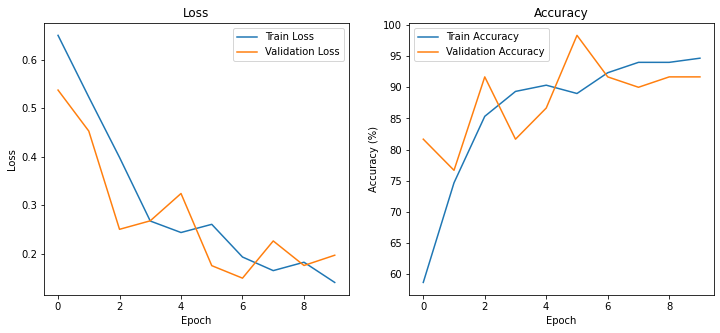

In [75]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=10):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_losses.append(train_loss / train_total)
        train_accuracies.append(100 * train_correct / train_total)
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%')

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_losses.append(val_loss / val_total)
        val_accuracies.append(100 * val_correct / val_total)
        print(f'Epoch {epoch+1}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%')    

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.show()

# Execute training and visualization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedVGG().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.NLLLoss()
train_model(model, train_loader, val_loader, optimizer, loss_fn)

